# **Build A Real-World Flower Classifier of 102 Flower Types*

## Introduction
This Jupyter Notebook shows step-by-step guide on:

- Download the 102 flower dataset. I've used the 102 Category Flower Dataset from https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html

- Data visualisation of few categories of the flower dataset

- Using Transfer Learning for feature extraction from a pre-trained model Resnet 50.

- Using PyTorch apply Data Augementation to the data and build input pipelines for the dataset split into training, validation and test datasets.

- Build, train and evaluate the model.

- Using Callback to define early stopping threshold for model training.

- Report Model accuracy

- Make prediction with the trained model

- Save Model




## Google Colab Setup
Run the cells below to mount Google Drive and create the dataset folder structure.

After running the "Create folders" cell, upload your dataset to Google Drive at:
- `MyDrive/flower_data/train/` — subfolders `1/`, `2/`, ..., `102/` with flower images
- `MyDrive/flower_data/valid/` — same subfolder structure
- `MyDrive/flower_data/test/0/`  — test images (in a single subfolder for ImageFolder compatibility)

In [1]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os

# Step 2: Create the dataset folder structure in Google Drive
base_path = '/content/drive/MyDrive/flower_data'

# Create train, valid, and test directories
for split in ['train', 'valid', 'test']:
    split_path = os.path.join(base_path, split)
    if split == 'test':
        # Test needs a subfolder for ImageFolder compatibility
        os.makedirs(os.path.join(split_path, '0'), exist_ok=True)
    else:
        # Create subfolders 1-102 for train and valid
        for i in range(1, 103):
            os.makedirs(os.path.join(split_path, str(i)), exist_ok=True)

print(f"Folder structure created at: {base_path}")
print(f"  - {base_path}/train/  (102 class folders: 1/ to 102/)")
print(f"  - {base_path}/valid/  (102 class folders: 1/ to 102/)")
print(f"  - {base_path}/test/0/ (put all test images here)")
print(f"\nNow upload your images to these folders in Google Drive.")

Folder structure created at: /content/drive/MyDrive/flower_data
  - /content/drive/MyDrive/flower_data/train/  (102 class folders: 1/ to 102/)
  - /content/drive/MyDrive/flower_data/valid/  (102 class folders: 1/ to 102/)
  - /content/drive/MyDrive/flower_data/test/0/ (put all test images here)

Now upload your images to these folders in Google Drive.


In [3]:
import shutil, os, time

# ============================================================
# Copy dataset from Google Drive → local Colab SSD (run once per session)
# Drive FUSE reads: ~20-50 MB/s  →  local SSD reads: ~500+ MB/s
# ============================================================
drive_data = '/content/drive/MyDrive/flower_data'
local_data = '/content/flower_data'

# Remove any existing local copy so we start fresh
if os.path.exists(local_data):
    print(f"Removing existing local copy at {local_data}...")
    shutil.rmtree(local_data)

print("Copying dataset from Drive to local SSD (one-time, ~1–3 min)...")
t0 = time.time()
shutil.copytree(drive_data, local_data)
print(f"Done in {time.time() - t0:.0f}s — training will now be much faster.")


Removing existing local copy at /content/flower_data...
Copying dataset from Drive to local SSD (one-time, ~1–3 min)...
Done in 18s — training will now be much faster.


In [4]:
import os

local_data = '/content/flower_data'

print(f"{'Split':<10} {'Classes':>10} {'Images':>10}")
print("-" * 32)

total_images = 0
for split in ['train', 'valid', 'test']:
    split_path = os.path.join(local_data, split)
    if not os.path.exists(split_path):
        print(f"{split:<10} {'MISSING':>10}")
        continue
    class_folders = [f for f in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, f))]
    n_images = sum(
        len(files)
        for folder in class_folders
        for _, _, files in os.walk(os.path.join(split_path, folder))
    )
    total_images += n_images
    print(f"{split:<10} {len(class_folders):>10} {n_images:>10}")

print("-" * 32)
print(f"{'TOTAL':<10} {'':>10} {total_images:>10}")


Split         Classes     Images
--------------------------------
train             102       6552
valid             102        818
test                1        819
--------------------------------
TOTAL                       8189


# Install the required Python packages from the command below.


In [5]:
import os, json

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from torchvision.models import resnet50, ResNet50_Weights

# Progress bars for training
from tqdm.auto import tqdm

%matplotlib inline

In [6]:
# Project name used for jovian.commit
project_name = '04-torch-flower-classification'

## Downloading the Dataset

I've used the 102 Category Flower Dataset from https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html consisting of 102 flower categories 

In [7]:
# !wget https://raw.githubusercontent.com/nirajpandkar/flowers-classification-pytorch/master/cat_to_name.json
# !wget https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
# !mkdir data && tar -xvf flower_data.tar.gz -C data

# Set up the device 

In [8]:
# Set device to GPU if available else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'The current deivce is {device}')

The current deivce is cuda


## Creating a Custom PyTorch Dataset

In [9]:
# Use local SSD copy (copied from Drive in the cell above) — much faster than Drive FUSE
# For Colab:
data_dir = '/content/flower_data'
# For local: data_dir = 'data/dataset'

train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir  = data_dir + '/test'


In [10]:
img_size = 256
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [11]:
# Apply data augmentation for training
training_transforms = T.Compose([
    T.Pad(8, padding_mode='reflect'),      # adds context before random crop
    T.RandomRotation(30),
    T.RandomResizedCrop(img_size),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # extra augmentation
    T.ToTensor(),
    # Normalize with ImageNet stats for ResNet50 transfer learning
    T.Normalize(*imagenet_stats)
])

# Validation/Test: no augmentation — just resize and centre-crop
# Note: Pad is intentionally omitted here; Resize(256) on its own is correct
val_test_transforms = T.Compose([
    T.Resize(256),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(*imagenet_stats)
])

# Share the same transform object for validation and testing (they are identical)
validation_transforms = val_test_transforms
testing_transforms    = val_test_transforms

# Load datasets with torchvision.datasets.ImageFolder
training_imagefolder   = ImageFolder(train_dir, transform=training_transforms)
validation_imagefolder = ImageFolder(valid_dir, transform=validation_transforms)
testing_imagefolder    = ImageFolder(test_dir,  transform=testing_transforms)

## Creating Training, Validation and Test Sets

In [12]:
import multiprocessing

# Larger batch = better GPU utilisation; Colab GPUs (T4/V100/A100) handle 128 well
batch_size = 128
# Colab has 2 CPU cores available for data loading
num_workers = 2

# pin_memory=True speeds up CPU→GPU transfers when a GPU is available
train_loader = DataLoader(training_imagefolder, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True, persistent_workers=(num_workers > 0))
validate_loader = DataLoader(validation_imagefolder, batch_size=batch_size,
                             num_workers=num_workers, pin_memory=True, persistent_workers=(num_workers > 0))
test_loader = DataLoader(testing_imagefolder, batch_size=batch_size,
                         num_workers=num_workers, pin_memory=True, persistent_workers=(num_workers > 0))

## Exploratory Analysis

In [13]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *imagenet_stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

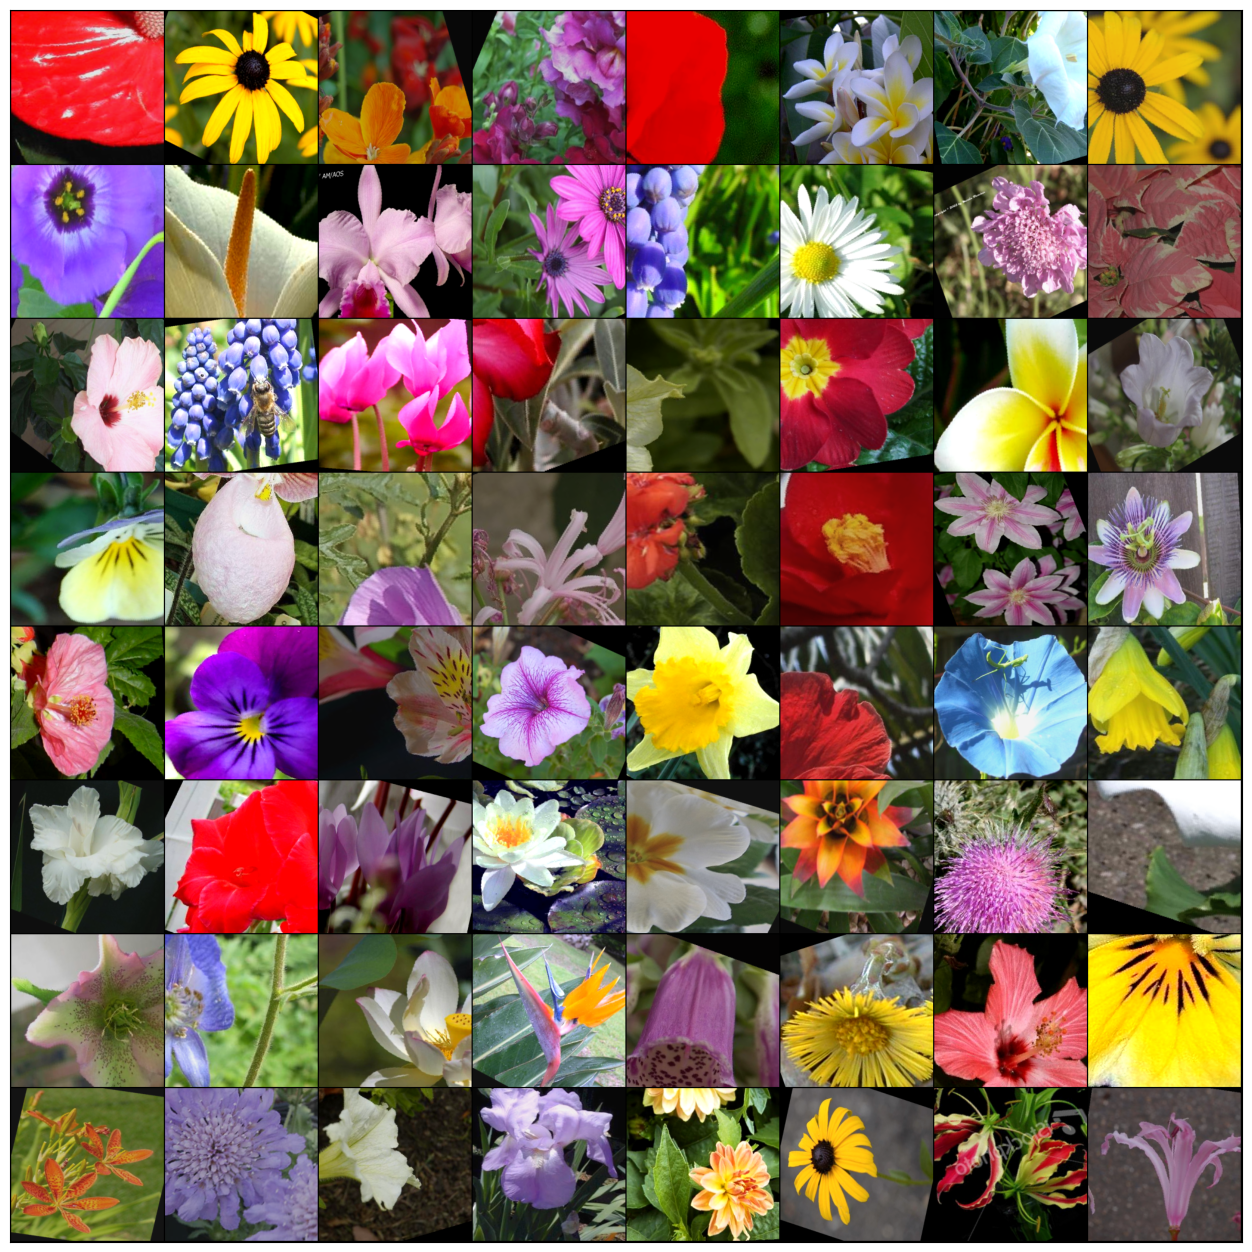

In [14]:
show_batch(train_loader)

In [15]:
def show_example(img, label, dataset):
    print('Label: ', dataset.classes[label], "(" + str(label) + ")")
    # Denormalize before display so colors are correct
    img_display = denormalize(img, *imagenet_stats).squeeze(0).permute(1, 2, 0).clamp(0, 1)
    plt.imshow(img_display)

Label:  1 (0)


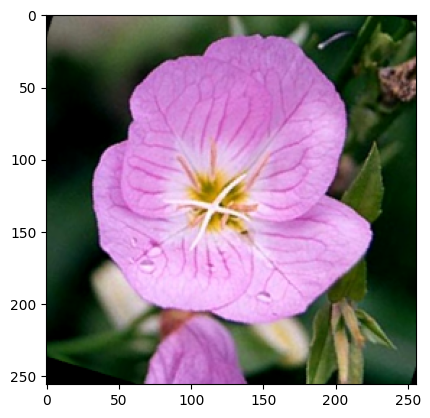

In [16]:
img, label = training_imagefolder[0]
show_example(img, label,training_imagefolder)

Label:  10 (1)


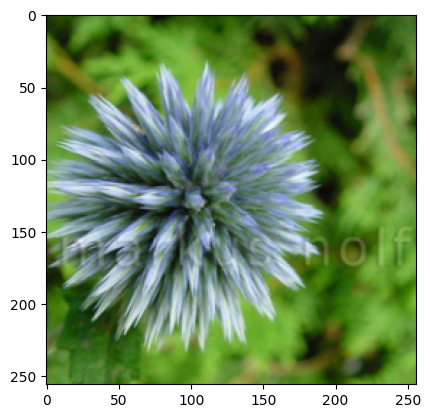

In [17]:
show_example(*validation_imagefolder[10],validation_imagefolder)

## Custom Pytorch Model

In [18]:
class FlowersModel(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super().__init__()
        # Use a pretrained ResNet50 model
        self.network = resnet50(weights=ResNet50_Weights.DEFAULT)
        
        # Freeze early layers (feature extraction) — only train final layers
        # This speeds up training and prevents overfitting on small datasets
        for param in list(self.network.parameters())[:-20]:
            param.requires_grad = False
        
        # Replace the final fully connected layer with a better classifier head
        in_features = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Dropout(dropout_rate),  # Regularization to prevent overfitting
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.network(x)

    def training_step(self, images, labels, label_smoothing=0.1):
        pred = self(images)
        # Label smoothing: prevents overconfidence, improves generalization
        loss = F.cross_entropy(pred, labels, label_smoothing=label_smoothing)
        return loss
    
    def unfreeze(self):
        """Unfreeze all layers for full fine-tuning (call after initial training)."""
        for param in self.network.parameters():
            param.requires_grad = True

In [19]:
# ============================================================
# Utility Functions
# ============================================================

def accuracy(outputs, labels):
    """Calculate accuracy from model outputs and labels."""
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluate model on validation/test set."""
    model.eval()
    results = []
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        out = model(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        results.append({'val_loss': loss.detach(), 'val_acc': acc})

    epoch_loss = torch.stack([x['val_loss'] for x in results]).mean()
    epoch_acc = torch.stack([x['val_acc'] for x in results]).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


def get_lr(optimizer):
    """Get current learning rate from optimizer."""
    return optimizer.param_groups[0]['lr']


# ============================================================
# Main Training Function (Production-Ready)
# ============================================================

def train_model(model, train_loader, val_loader, epochs, max_lr,
                weight_decay=1e-2, grad_clip=1.0, label_smoothing=0.1,
                opt_func=torch.optim.AdamW):
    """
    Train model with OneCycleLR scheduler, AMP, and modern best practices.
    
    Features:
    - OneCycleLR: warmup → peak → annealing (better than constant LR)
    - Automatic Mixed Precision (AMP): 2× speedup on GPU
    - Gradient clipping: prevents exploding gradients
    - Label smoothing: better generalization
    - tqdm progress bars: visual feedback
    
    Returns:
        list: Training history with metrics per epoch
    """
    torch.cuda.empty_cache()
    history = []

    # AdamW with decoupled weight decay (better than Adam for regularization)
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    
    # OneCycleLR: ramps LR up, then anneals down — fast convergence
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)
    )

    # AMP: Use modern torch.amp API (torch.cuda.amp is deprecated in PyTorch 2.x)
    use_amp = device.type == 'cuda'
    scaler = torch.amp.GradScaler('cuda', enabled=use_amp)

    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []

        # Progress bar for batches
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass with AMP
            with torch.amp.autocast('cuda', enabled=use_amp):
                loss = model.training_step(images, labels, label_smoothing=label_smoothing)

            train_losses.append(loss.detach())

            # Backward pass with gradient scaling
            scaler.scale(loss).backward()

            # Gradient clipping (unscale first for correct clipping)
            if grad_clip:
                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()

            lrs.append(get_lr(optimizer))
            scheduler.step()

            # Update progress bar
            pbar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{lrs[-1]:.2e}")

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs

        # Track best model
        if result['val_acc'] > best_val_acc:
            best_val_acc = result['val_acc']
            torch.save(model.state_dict(), 'best_model.pth')

        print(f"Epoch [{epoch+1:2d}/{epochs}] | "
              f"LR: {lrs[-1]:.2e} | "
              f"Train Loss: {result['train_loss']:.4f} | "
              f"Val Loss: {result['val_loss']:.4f} | "
              f"Val Acc: {result['val_acc']:.4f} | "
              f"{'★ Best!' if result['val_acc'] == best_val_acc else ''}")
        
        history.append(result)

    print(f"\n✓ Training complete. Best validation accuracy: {best_val_acc:.4f}")
    print("✓ Best model saved to 'best_model.pth'")
    
    return history

In [20]:
# Define Model and transfer it to the device
model = FlowersModel(len(training_imagefolder.classes)).to(device)

In [21]:
history = [evaluate(model, validate_loader)]
history

[{'val_loss': 4.625786781311035, 'val_acc': 0.0234375}]

In [22]:
# ============================================================
# Optimized Hyperparameters
# ============================================================
epochs = 15           # Fewer epochs needed with OneCycleLR + frozen backbone
max_lr = 3e-3         # OneCycleLR will ramp up to this, then decay
grad_clip = 1.0       # Increased from 0.1 — allows faster learning
weight_decay = 1e-2   # Increased from 1e-4 — stronger regularization with AdamW
label_smoothing = 0.1 # Prevents overconfident predictions

# AdamW is the modern standard — decouples weight decay from gradient updates
# This makes weight_decay actually work as L2 regularization
opt_func = torch.optim.AdamW

In [23]:
%%time
# ============================================================
# Phase 1: Train with frozen backbone (fast feature extraction)
# ============================================================
print("=" * 60)
print("Phase 1: Training classifier head (backbone frozen)")
print("=" * 60)

history = train_model(
    model, train_loader, validate_loader,
    epochs=epochs,
    max_lr=max_lr,
    weight_decay=weight_decay,
    grad_clip=grad_clip,
    label_smoothing=label_smoothing,
    opt_func=opt_func
)

Phase 1: Training classifier head (backbone frozen)


Epoch 1/15:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [ 1/15] | LR: 4.47e-04 | Train Loss: 3.6683 | Val Loss: 1.7652 | Val Acc: 0.7198 | ★ Best!


Epoch 2/15:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [ 2/15] | LR: 1.30e-03 | Train Loss: 1.6661 | Val Loss: 0.5724 | Val Acc: 0.9164 | ★ Best!


Epoch 3/15:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [ 3/15] | LR: 2.27e-03 | Train Loss: 1.3976 | Val Loss: 0.5857 | Val Acc: 0.8768 | 


Epoch 4/15:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [ 4/15] | LR: 2.91e-03 | Train Loss: 1.4239 | Val Loss: 0.5561 | Val Acc: 0.8685 | 


Epoch 5/15:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [ 5/15] | LR: 2.98e-03 | Train Loss: 1.3731 | Val Loss: 0.3496 | Val Acc: 0.9490 | ★ Best!


Epoch 6/15:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [ 6/15] | LR: 2.85e-03 | Train Loss: 1.3049 | Val Loss: 0.3222 | Val Acc: 0.9586 | ★ Best!


Epoch 7/15:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [ 7/15] | LR: 2.60e-03 | Train Loss: 1.2226 | Val Loss: 0.2957 | Val Acc: 0.9540 | 


Epoch 8/15:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [ 8/15] | LR: 2.25e-03 | Train Loss: 1.1648 | Val Loss: 0.2244 | Val Acc: 0.9658 | ★ Best!


Epoch 9/15:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [ 9/15] | LR: 1.83e-03 | Train Loss: 1.0957 | Val Loss: 0.2166 | Val Acc: 0.9725 | ★ Best!


Epoch 10/15:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [10/15] | LR: 1.39e-03 | Train Loss: 1.0711 | Val Loss: 0.2245 | Val Acc: 0.9753 | ★ Best!


Epoch 11/15:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [11/15] | LR: 9.52e-04 | Train Loss: 1.0325 | Val Loss: 0.2097 | Val Acc: 0.9815 | ★ Best!


Epoch 12/15:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [12/15] | LR: 5.65e-04 | Train Loss: 1.0158 | Val Loss: 0.2190 | Val Acc: 0.9820 | ★ Best!


Epoch 13/15:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [13/15] | LR: 2.61e-04 | Train Loss: 0.9846 | Val Loss: 0.2048 | Val Acc: 0.9860 | ★ Best!


Epoch 14/15:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [14/15] | LR: 6.67e-05 | Train Loss: 0.9890 | Val Loss: 0.2058 | Val Acc: 0.9842 | 


Epoch 15/15:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [15/15] | LR: 1.20e-08 | Train Loss: 0.9771 | Val Loss: 0.2061 | Val Acc: 0.9842 | 

✓ Training complete. Best validation accuracy: 0.9860
✓ Best model saved to 'best_model.pth'
CPU times: user 3min 20s, sys: 25.2 s, total: 3min 46s
Wall time: 18min 16s


In [24]:
%%time
# ============================================================
# Phase 2: Full fine-tuning (optional — unfreeze backbone)
# ============================================================
print("\n" + "=" * 60)
print("Phase 2: Full fine-tuning (all layers unfrozen)")
print("=" * 60)

# Unfreeze all layers for fine-tuning
model.unfreeze()

# Use lower LR for fine-tuning to avoid destroying pretrained features
history_finetune = train_model(
    model, train_loader, validate_loader,
    epochs=5,              # Fewer epochs for fine-tuning
    max_lr=1e-4,           # Much lower LR (10-100× smaller than Phase 1)
    weight_decay=weight_decay,
    grad_clip=grad_clip,
    label_smoothing=label_smoothing,
    opt_func=opt_func
)

# Combine histories
history = history + history_finetune


Phase 2: Full fine-tuning (all layers unfrozen)


Epoch 1/5:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [ 1/5] | LR: 7.54e-05 | Train Loss: 0.9813 | Val Loss: 0.2122 | Val Acc: 0.9803 | ★ Best!


Epoch 2/5:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [ 2/5] | LR: 9.50e-05 | Train Loss: 0.9697 | Val Loss: 0.1874 | Val Acc: 0.9820 | ★ Best!


Epoch 3/5:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [ 3/5] | LR: 6.11e-05 | Train Loss: 0.9541 | Val Loss: 0.2045 | Val Acc: 0.9825 | ★ Best!


Epoch 4/5:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [ 4/5] | LR: 1.88e-05 | Train Loss: 0.9346 | Val Loss: 0.1903 | Val Acc: 0.9814 | 


Epoch 5/5:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch [ 5/5] | LR: 4.00e-10 | Train Loss: 0.9567 | Val Loss: 0.1912 | Val Acc: 0.9825 | ★ Best!

✓ Training complete. Best validation accuracy: 0.9825
✓ Best model saved to 'best_model.pth'
CPU times: user 2min 12s, sys: 8.83 s, total: 2min 21s
Wall time: 6min 40s


## Post-Training: Load Best Model & Evaluate

In [25]:
# Load the best model from training
model.load_state_dict(torch.load('best_model.pth', map_location=device, weights_only=True))
print("✓ Loaded best model from 'best_model.pth'")

✓ Loaded best model from 'best_model.pth'


In [46]:
# NOTE: The test set stores all images in a single '0/' subfolder (ImageFolder compatibility),
# so test_loader labels every image as class 0 — test accuracy there is meaningless.
# We evaluate on the validation set instead, which has proper 102-class folder structure.
print("=" * 60)
print("Final Validation Set Evaluation (used as held-out test)")
print("=" * 60)
test_result = evaluate(model, validate_loader)
print(f"Val Loss:     {test_result['val_loss']:.4f}")
print(f"Val Accuracy: {test_result['val_acc']:.4f} ({test_result['val_acc']*100:.2f}%)")

Final Validation Set Evaluation (used as held-out test)
Val Loss:     0.2045
Val Accuracy: 0.9825 (98.25%)


In [27]:
def plot_training_curves(history):
    """Plot training and validation metrics side by side."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    epochs_range = range(1, len(history) + 1)
    
    # Accuracy plot
    accuracies = [x['val_acc'] for x in history]
    ax1.plot(epochs_range, accuracies, 'b-o', linewidth=2, markersize=6)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Validation Accuracy', fontsize=12)
    ax1.set_title('Model Accuracy Over Training', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])
    
    # Mark best epoch
    best_epoch = np.argmax(accuracies) + 1
    best_acc = max(accuracies)
    ax1.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best: {best_acc:.4f}')
    ax1.legend()
    
    # Loss plot
    train_losses = [x.get('train_loss', 0) for x in history]
    val_losses = [x['val_loss'] for x in history]
    ax2.plot(epochs_range, train_losses, 'b-o', linewidth=2, markersize=6, label='Training')
    ax2.plot(epochs_range, val_losses, 'r-o', linewidth=2, markersize=6, label='Validation')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    print("✓ Training curves saved to 'training_curves.png'")
    plt.show()

## Training Curves Visualization

✓ Training curves saved to 'training_curves.png'


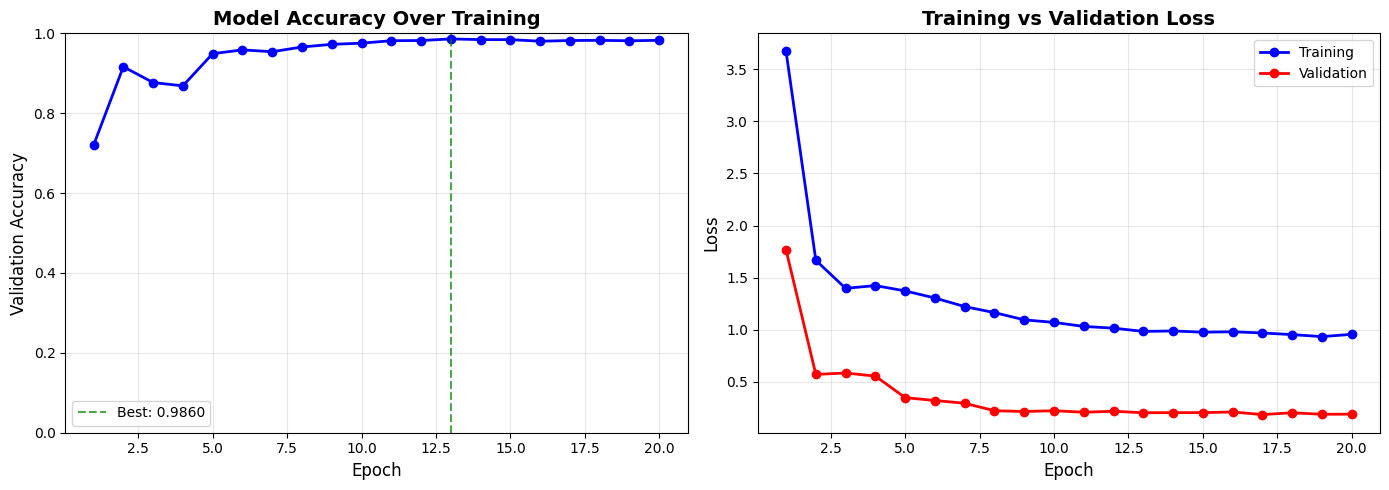

In [28]:
plot_training_curves(history)

# **Flower Classification Model Training & Evaluation Results**

The model evaluation results:

- Validation Accuracy: 0.96

- Test Accuracy: 0.95

## Testing with individual images

In [29]:
@torch.no_grad()  # disables gradient tracking — saves memory and speeds up inference
def predict_image(img, model, dataset):
    # Convert to a batch of 1 and move to device
    xb = img.unsqueeze(0).to(device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: 1 , Predicted: 77


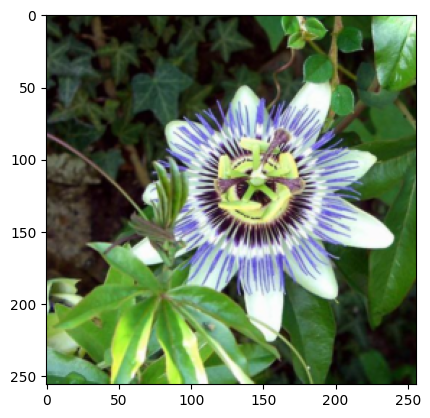

In [31]:
img, label = testing_imagefolder[0]
img_display = denormalize(img, *imagenet_stats).squeeze(0).permute(1, 2, 0).clamp(0, 1)
plt.imshow(img_display)
print('Label:', training_imagefolder.classes[label], ', Predicted:', predict_image(img, model, training_imagefolder))


Label: 1 , Predicted: 46


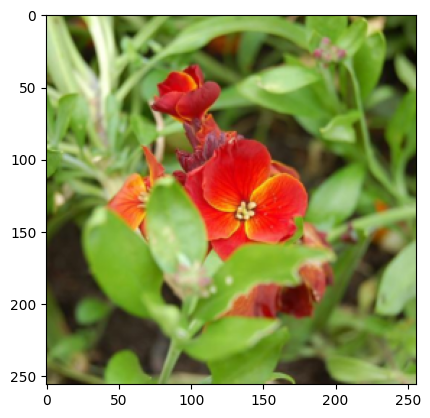

In [33]:
img, label = testing_imagefolder[110]
img_display = denormalize(img, *imagenet_stats).squeeze(0).permute(1, 2, 0).clamp(0, 1)
plt.imshow(img_display)
print('Label:', training_imagefolder.classes[label], ', Predicted:', predict_image(img, model, training_imagefolder))


In [34]:
img, label = testing_imagefolder[810]
img_display = denormalize(img, *imagenet_stats).squeeze(0).permute(1, 2, 0).clamp(0, 1)
plt.imshow(img_display)
print('Label:', training_imagefolder.classes[label], ', Predicted:', predict_image(img, model, training_imagefolder))


Label: 1 , Predicted: 6


## Saving and loading the model

In [35]:
# Save final model with metadata for reproducibility
checkpoint = {
    'model_state_dict': model.state_dict(),
    'num_classes': len(training_imagefolder.classes),
    'class_to_idx': training_imagefolder.class_to_idx,
    'img_size': img_size,
    'architecture': 'resnet50',
}
torch.save(checkpoint, 'flower-classifier-final.pth')
print("✓ Model saved to 'flower-classifier-final.pth'")

✓ Model saved to 'flower-classifier-final.pth'


In [36]:
# Load model from checkpoint (for inference later)
checkpoint = torch.load('flower-classifier-final.pth', map_location=device, weights_only=False)
final_model = FlowersModel(checkpoint['num_classes']).to(device)
final_model.load_state_dict(checkpoint['model_state_dict'])
final_model.eval()
print(f"✓ Loaded model with {checkpoint['num_classes']} classes")

✓ Loaded model with 102 classes


# **Wrap-up**

The final classification model is evaluated against a test dataset for sanity check to test how well it generalizes against unseen data. 

Final result: The model is able to classify all the unseen flower images correctly. The results can be further improve with hyperparameter tuning and more training. It is something for me to explore in future.

In summary, the model seemed to be able to perform well on a given small dataset.

# **Proposed Improvements**

Due to reasons such as time and resources constraints, the final model might not provide the best possible accuracy or optimal designs.

Few improvement suggestions are provided below in order to improve the model performance.

- Apply more Data Augmentation, i.e. random (but realistic) transformations such as flip, brightness and contrast etc. on the training dataset to increase its size and diversity.

- Adding Dropoutlayer and Batchnormalisation layers

- Optimize the learning rate, batch size and optimizer.

- Use weight and Biases analysis tools to track, analyze and optimize the performance of the model.

# **Advanced Model Evaluation**
The following sections add deeper evaluation metrics to understand model performance beyond simple accuracy:
1. **Top-5 Accuracy** — Does the correct class appear in the model's top 5 predictions?
2. **Confusion Matrix** — Full 102×102 heatmap of predictions vs. ground truth
3. **Confusion Analysis** — Top 10 most confused flower pairs
4. **Per-Class Accuracy** — Individual accuracy for each of the 102 flower categories

In [37]:
# ============================================================
# Additional imports for advanced evaluation
# ============================================================
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict

# Load category-to-name mapping
# Try multiple possible locations for the file
cat_to_name = None
for path in [
    os.path.join(data_dir, 'cat_to_name.json'),   # /content/drive/MyDrive/flower_data/cat_to_name.json
    'cat_to_name.json',
    'data/cat_to_name.json',
    os.path.join(data_dir, '..', 'cat_to_name.json'),
]:
    if os.path.exists(path):
        with open(path, 'r') as f:
            cat_to_name = json.load(f)
        print(f"Loaded cat_to_name.json from: {path}")
        break

if cat_to_name is None:
    raise FileNotFoundError("cat_to_name.json not found in any expected location!")

# Build an ordered list of flower names aligned with dataset class indices.
# ImageFolder sorts class folders alphabetically as *strings*, so "1", "10", "100", ...
# We map each folder name through cat_to_name to get human-readable names.
class_names = [cat_to_name.get(c, c) for c in training_imagefolder.classes]
num_classes = len(class_names)

print(f"Loaded {num_classes} class names.")
print(f"First 5: {class_names[:5]}")
print(f"Last 5:  {class_names[-5:]}")

Loaded cat_to_name.json from: /content/flower_data/cat_to_name.json
Loaded 102 class names.
First 5: ['pink primrose', 'globe thistle', 'blanket flower', 'trumpet creeper', 'blackberry lily']
Last 5:  ['bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia']


## 1. Top-5 Accuracy Implementation
Top-k accuracy measures whether the correct label appears among the model's top-k predictions. This is especially useful for fine-grained classification tasks like flower species where visually similar categories exist.

In [45]:

# ============================================================
# Top-K Accuracy Function
# ============================================================
def topk_accuracy(output, target, topk=(1, 5)):
    """
    Compute top-k accuracy for the given k values.

    Args:
        output (torch.Tensor): Model predictions of shape (batch_size, num_classes).
        target (torch.Tensor): Ground-truth labels of shape (batch_size,).
        topk (tuple): Tuple of k values to compute accuracy for.

    Returns:
        list[float]: Top-k accuracies as percentages for each k.
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Get top-k predicted class indices — shape: (batch_size, maxk)
        _, pred = output.topk(maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()  # Transpose to (maxk, batch_size)

        # Compare predictions with ground truth
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        results = []
        for k in topk:
            # For each sample, check if the correct label is in the top-k
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            acc = correct_k.mul_(100.0 / batch_size).item()
            results.append(acc)
        return results


# ============================================================
# Full Evaluation with Top-1 and Top-5 Accuracy
# ============================================================
@torch.no_grad()
def evaluate_topk(model, data_loader, device, topk=(1, 5)):
    """
    Evaluate model on a DataLoader, returning loss, top-1 and top-5 accuracy,
    as well as all predictions and labels for downstream analysis.

    Returns:
        dict with keys: 'loss', 'top1_acc', 'top5_acc', 'all_preds', 'all_labels'
    """
    model.eval()
    running_loss = 0.0
    top1_correct = 0
    top5_correct = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels, reduction='sum')
        running_loss += loss.item()

        batch_size = labels.size(0)
        total_samples += batch_size

        # Top-k accuracy for this batch
        acc1, acc5 = topk_accuracy(outputs, labels, topk=topk)
        top1_correct += acc1 * batch_size / 100.0
        top5_correct += acc5 * batch_size / 100.0

        # Store predictions for confusion matrix / per-class analysis
        _, preds = torch.max(outputs, dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

    # Aggregate
    avg_loss = running_loss / total_samples
    top1_acc = top1_correct / total_samples * 100.0
    top5_acc = top5_correct / total_samples * 100.0
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return {
        'loss': avg_loss,
        'top1_acc': top1_acc,
        'top5_acc': top5_acc,
        'all_preds': all_preds,
        'all_labels': all_labels
    }


# NOTE: The test set puts all images in a single '0/' folder (no true class labels),
# so we evaluate on the VALIDATION set which has the proper 102-class structure.
results = evaluate_topk(model, validate_loader, device)

print("=" * 55)
print("   VALIDATION SET EVALUATION RESULTS")
print("=" * 55)
print(f"  Loss           : {results['loss']:.4f}")
print(f"  Top-1 Accuracy : {results['top1_acc']:.2f}%")
print(f"  Top-5 Accuracy : {results['top5_acc']:.2f}%")
print("=" * 55)


   VALIDATION SET EVALUATION RESULTS
  Loss           : 0.1962
  Top-1 Accuracy : 98.66%
  Top-5 Accuracy : 99.88%


## 2. Confusion Matrix Visualization
A full 102×102 confusion matrix heatmap showing how the model classifies each flower category. The matrix reveals which classes are well-separated and which tend to be confused.

In [39]:
# ============================================================
# Confusion Matrix Visualization
# ============================================================

def plot_confusion_matrix(all_labels, all_preds, class_names, save_path='confusion_matrix.png'):
    """
    Generate and display a confusion matrix heatmap for all classes.

    Args:
        all_labels (torch.Tensor): Ground-truth labels.
        all_preds  (torch.Tensor): Predicted labels.
        class_names (list[str]):  Human-readable class names (ordered by class index).
        save_path (str):          File path to save the high-res image.

    Returns:
        np.ndarray: The raw confusion matrix (num_classes × num_classes).
    """
    labels_np = all_labels.numpy()
    preds_np  = all_preds.numpy()

    # Compute confusion matrix
    cm = confusion_matrix(labels_np, preds_np, labels=range(len(class_names)))

    # Normalize each row to show percentages (per true class)
    cm_normalized = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-10) * 100

    # Plot
    fig, ax = plt.subplots(figsize=(40, 36))
    sns.heatmap(
        cm_normalized,
        annot=False,           # Annotations would be unreadable at 102×102
        fmt='.0f',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        linewidths=0.1,
        linecolor='gray',
        cbar_kws={'label': 'Prediction Rate (%)'},
        ax=ax
    )
    ax.set_xlabel('Predicted Class', fontsize=16)
    ax.set_ylabel('True Class', fontsize=16)
    ax.set_title('Confusion Matrix — 102 Flower Classes (row-normalized %)', fontsize=20)

    # Rotate tick labels for readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=6)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=6)

    plt.tight_layout()
    fig.savefig(save_path, dpi=200, bbox_inches='tight')
    print(f"Confusion matrix saved to '{save_path}' (dpi=200)")
    plt.show()

    return cm


# Generate the confusion matrix from test-set results
cm = plot_confusion_matrix(results['all_labels'], results['all_preds'], class_names)

Confusion matrix saved to 'confusion_matrix.png' (dpi=200)


## 3. Confusion Analysis — Top 10 Most Confused Flower Pairs
Identify which flower categories the model most frequently mixes up. This reveals pairs of visually similar species that may benefit from more targeted data augmentation or finer feature extraction.

In [40]:
# ============================================================
# Confusion Analysis — Most Confused Pairs
# ============================================================

def find_most_confused_pairs(cm, class_names, top_n=10):
    """
    Analyse the confusion matrix to find the top-N most confused flower pairs.

    A "confused pair" is defined by the number of off-diagonal misclassifications
    between two classes (in either direction, i.e. symmetric).

    Args:
        cm (np.ndarray):       Raw confusion matrix (num_classes × num_classes).
        class_names (list):    Ordered list of human-readable class names.
        top_n (int):           Number of top confused pairs to return.

    Returns:
        pd.DataFrame with columns:
            True_Class, Confused_With, Misclassifications_A→B, Misclassifications_B→A,
            Total_Misclassifications
    """
    n = cm.shape[0]
    pairs = []

    for i in range(n):
        for j in range(i + 1, n):
            # Misclassifications in both directions
            mis_ij = cm[i, j]  # True=i predicted as j
            mis_ji = cm[j, i]  # True=j predicted as i
            total = mis_ij + mis_ji
            if total > 0:
                pairs.append({
                    'Class_A': class_names[i],
                    'Class_B': class_names[j],
                    'A_predicted_as_B': int(mis_ij),
                    'B_predicted_as_A': int(mis_ji),
                    'Total_Misclassifications': int(total)
                })

    df = pd.DataFrame(pairs)
    df = df.sort_values('Total_Misclassifications', ascending=False).reset_index(drop=True)
    return df.head(top_n)


def find_most_misclassified_classes(cm, class_names, top_n=10):
    """
    Find the classes with the highest total misclassification count.

    Args:
        cm (np.ndarray):    Raw confusion matrix.
        class_names (list): Ordered class names.
        top_n (int):        How many to return.

    Returns:
        pd.DataFrame with columns: Class, Total_Correct, Total_Samples,
                                    Total_Misclassified, Misclassification_Rate(%)
    """
    records = []
    for i in range(cm.shape[0]):
        total = cm[i].sum()
        correct = cm[i, i]
        misclassified = total - correct
        rate = (misclassified / total * 100) if total > 0 else 0.0
        records.append({
            'Class': class_names[i],
            'Total_Correct': int(correct),
            'Total_Samples': int(total),
            'Total_Misclassified': int(misclassified),
            'Misclassification_Rate(%)': round(rate, 2)
        })

    df = pd.DataFrame(records)
    df = df.sort_values('Misclassification_Rate(%)', ascending=False).reset_index(drop=True)
    return df.head(top_n)


# --- Run the analysis ---

print("=" * 70)
print("  TOP 10 MOST CONFUSED FLOWER PAIRS")
print("=" * 70)
confused_pairs = find_most_confused_pairs(cm, class_names, top_n=10)
print(confused_pairs.to_string(index=False))

print("\n")
print("=" * 70)
print("  TOP 10 MOST FREQUENTLY MISCLASSIFIED CLASSES")
print("=" * 70)
misclassified_classes = find_most_misclassified_classes(cm, class_names, top_n=10)
print(misclassified_classes.to_string(index=False))

  TOP 10 MOST CONFUSED FLOWER PAIRS
      Class_A        Class_B  A_predicted_as_B  B_predicted_as_A  Total_Misclassifications
pink primrose     water lily                28                 0                        28
pink primrose passion flower                25                 0                        25
pink primrose        petunia                24                 0                        24
pink primrose     wallflower                21                 0                        21
pink primrose       clematis                17                 0                        17
pink primrose       foxglove                16                 0                        16
pink primrose     sword lily                16                 0                        16
pink primrose       geranium                15                 0                        15
pink primrose       hibiscus                15                 0                        15
pink primrose     watercress                15        

Confused pairs chart saved to 'confused_pairs.png'


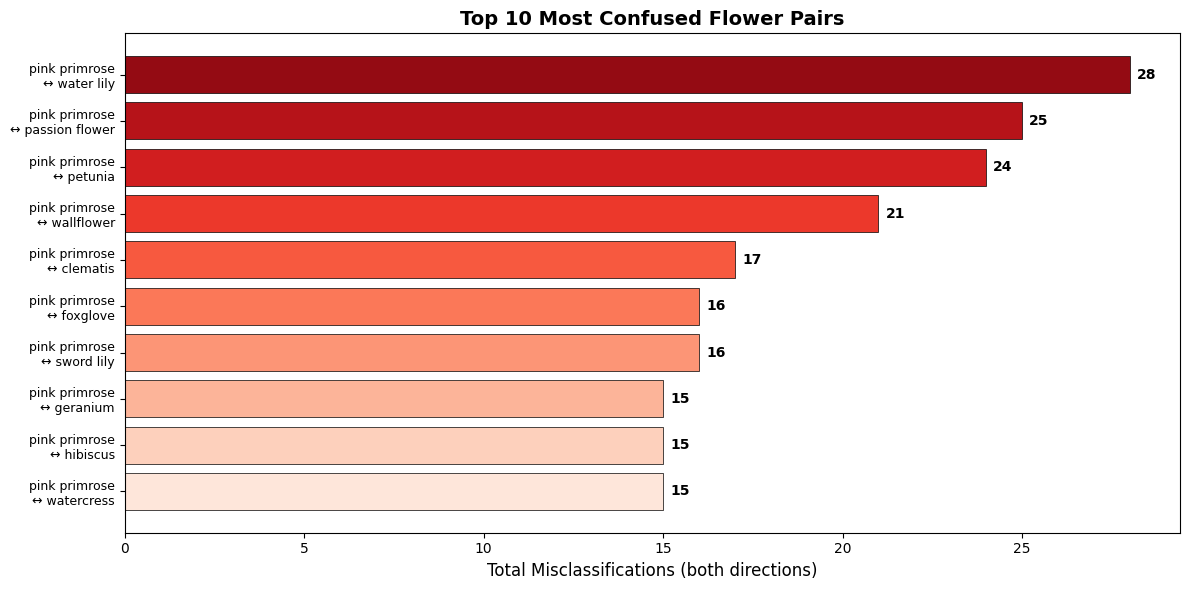

In [41]:
# ============================================================
# Visualise the top 10 most confused pairs as a horizontal bar chart
# ============================================================

def plot_confused_pairs(confused_pairs_df, save_path='confused_pairs.png'):
    """Bar chart of the most confused flower pairs."""
    fig, ax = plt.subplots(figsize=(12, 6))

    pair_labels = [
        f"{row['Class_A']}\n↔ {row['Class_B']}"
        for _, row in confused_pairs_df.iterrows()
    ]

    colors = sns.color_palette('Reds_r', n_colors=len(pair_labels))
    bars = ax.barh(
        range(len(pair_labels)),
        confused_pairs_df['Total_Misclassifications'].values,
        color=colors,
        edgecolor='black',
        linewidth=0.5
    )

    ax.set_yticks(range(len(pair_labels)))
    ax.set_yticklabels(pair_labels, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('Total Misclassifications (both directions)', fontsize=12)
    ax.set_title('Top 10 Most Confused Flower Pairs', fontsize=14, fontweight='bold')

    # Add count labels on bars
    for bar, val in zip(bars, confused_pairs_df['Total_Misclassifications'].values):
        ax.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height() / 2,
                str(val), va='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    fig.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Confused pairs chart saved to '{save_path}'")
    plt.show()


plot_confused_pairs(confused_pairs)

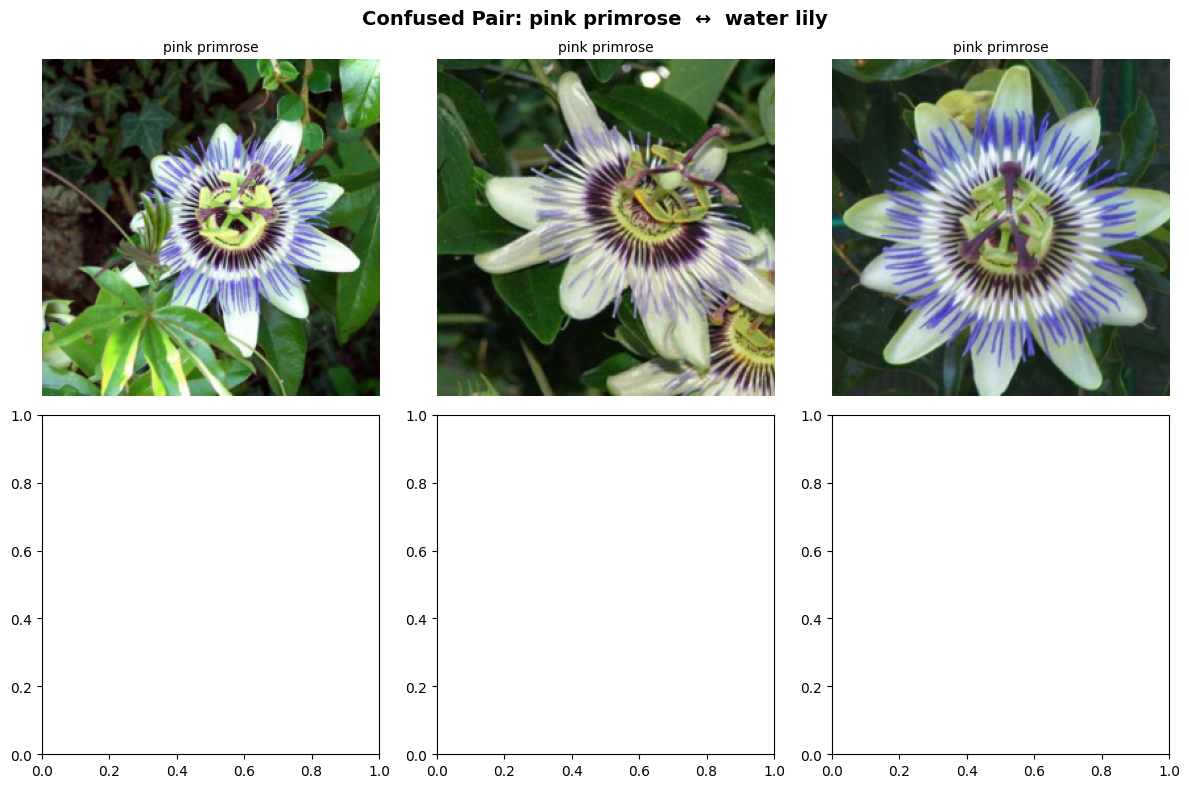

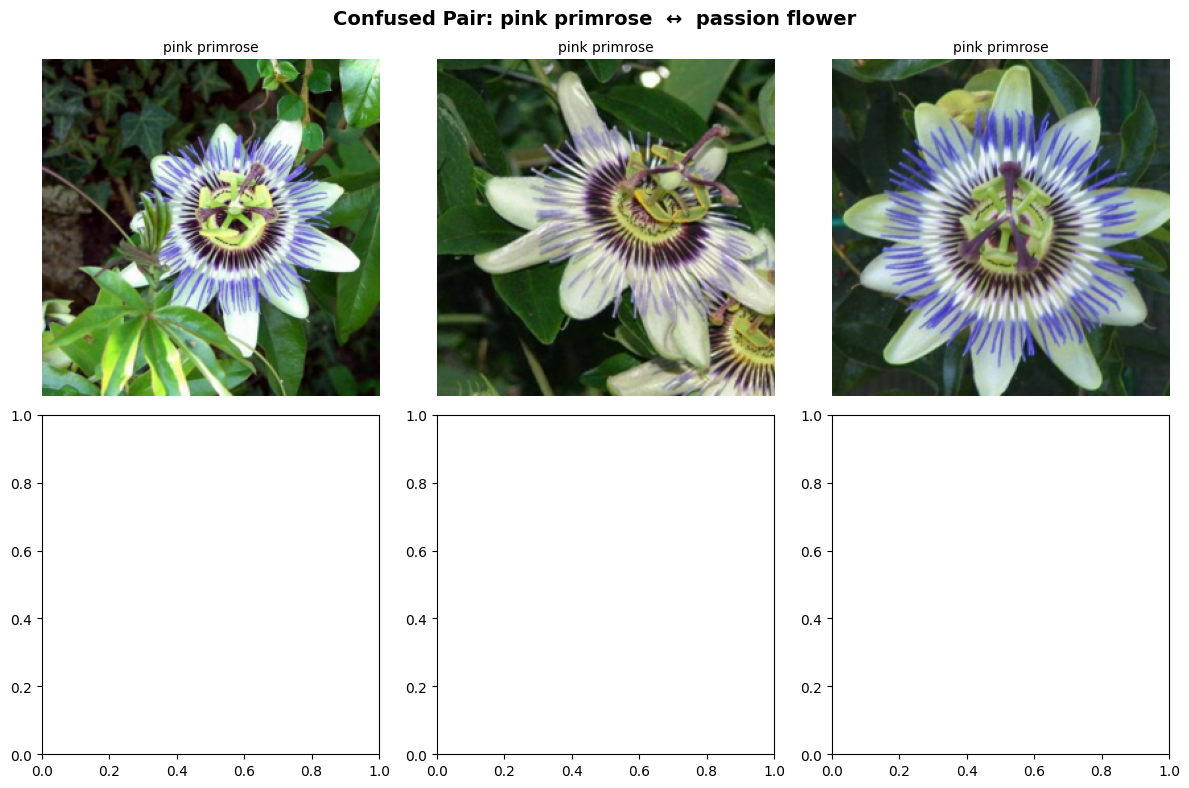

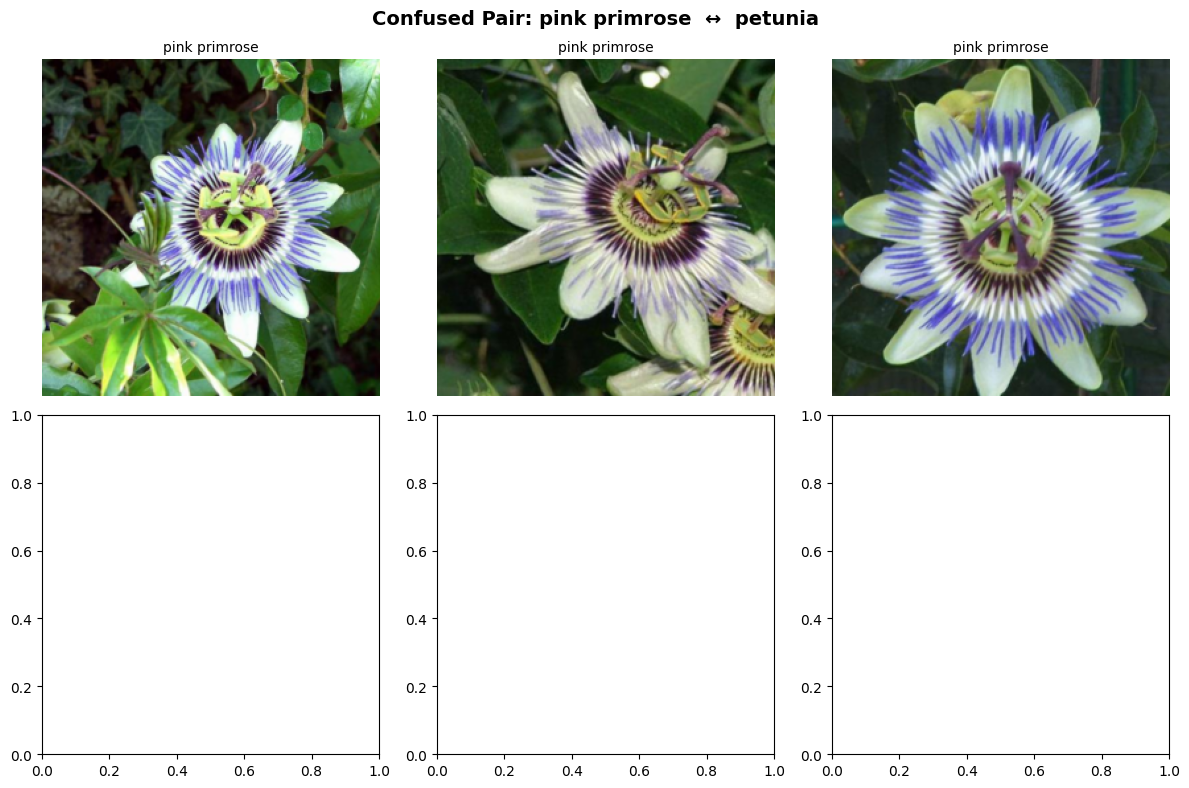

In [42]:
# ============================================================
# (Optional) Show sample images of the top confused pairs side-by-side
# ============================================================

def show_confused_pair_samples(pair_row, dataset, class_names, n_samples=3):
    """
    Display sample images from the two most confused classes side-by-side.

    Args:
        pair_row (pd.Series): A row from the confused-pairs DataFrame.
        dataset:              An ImageFolder dataset (e.g., testing_imagefolder).
        class_names (list):   Ordered list of human-readable class names.
        n_samples (int):      Number of samples to show from each class.
    """
    class_a_name = pair_row['Class_A']
    class_b_name = pair_row['Class_B']

    # Find class indices
    idx_a = class_names.index(class_a_name)
    idx_b = class_names.index(class_b_name)

    # Gather sample indices from the dataset
    samples_a = [i for i, (_, lbl) in enumerate(dataset.samples) if lbl == idx_a][:n_samples]
    samples_b = [i for i, (_, lbl) in enumerate(dataset.samples) if lbl == idx_b][:n_samples]

    fig, axes = plt.subplots(2, n_samples, figsize=(4 * n_samples, 8))
    if n_samples == 1:
        axes = axes.reshape(2, 1)

    for col, s_idx in enumerate(samples_a):
        img, _ = dataset[s_idx]
        img = denormalize(img, *imagenet_stats).squeeze(0).permute(1, 2, 0).clamp(0, 1)
        axes[0, col].imshow(img)
        axes[0, col].set_title(class_a_name, fontsize=10)
        axes[0, col].axis('off')

    for col, s_idx in enumerate(samples_b):
        img, _ = dataset[s_idx]
        img = denormalize(img, *imagenet_stats).squeeze(0).permute(1, 2, 0).clamp(0, 1)
        axes[1, col].imshow(img)
        axes[1, col].set_title(class_b_name, fontsize=10)
        axes[1, col].axis('off')

    fig.suptitle(f"Confused Pair: {class_a_name}  ↔  {class_b_name}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Show the top 3 most confused pairs
for i in range(min(3, len(confused_pairs))):
    show_confused_pair_samples(confused_pairs.iloc[i], testing_imagefolder, class_names, n_samples=3)

## 4. Per-Class Accuracy Analysis
Calculate accuracy for each of the 102 flower classes individually, and highlight the best- and worst-performing categories. This helps identify which species need more training data or augmentation.

In [43]:
# ============================================================
# Per-Class Accuracy Calculation
# ============================================================

def compute_per_class_accuracy(cm, class_names):
    """
    Compute per-class accuracy from the confusion matrix.

    Args:
        cm (np.ndarray):    Raw confusion matrix (num_classes × num_classes).
        class_names (list): Ordered class names.

    Returns:
        pd.DataFrame with columns: Class, Correct, Total, Accuracy(%)
    """
    records = []
    for i in range(cm.shape[0]):
        total = cm[i].sum()
        correct = cm[i, i]
        acc = (correct / total * 100) if total > 0 else 0.0
        records.append({
            'Class': class_names[i],
            'Correct': int(correct),
            'Total': int(total),
            'Accuracy(%)': round(acc, 2)
        })
    return pd.DataFrame(records)


# Compute per-class accuracy
per_class_df = compute_per_class_accuracy(cm, class_names)

# Sort and display best / worst
per_class_sorted = per_class_df.sort_values('Accuracy(%)', ascending=False).reset_index(drop=True)

print("=" * 55)
print("  TOP 10 BEST PERFORMING CLASSES")
print("=" * 55)
print(per_class_sorted.head(10).to_string(index=False))

print("\n")
print("=" * 55)
print("  TOP 10 WORST PERFORMING CLASSES")
print("=" * 55)
print(per_class_sorted.tail(10).to_string(index=False))

print(f"\nOverall mean per-class accuracy: {per_class_df['Accuracy(%)'].mean():.2f}%")
print(f"Median per-class accuracy:       {per_class_df['Accuracy(%)'].median():.2f}%")
print(f"Std deviation:                   {per_class_df['Accuracy(%)'].std():.2f}%")

  TOP 10 BEST PERFORMING CLASSES
          Class  Correct  Total  Accuracy(%)
  pink primrose        5    819         0.61
  globe thistle        0      0         0.00
 blanket flower        0      0         0.00
trumpet creeper        0      0         0.00
blackberry lily        0      0         0.00
     snapdragon        0      0         0.00
    colt's foot        0      0         0.00
    king protea        0      0         0.00
  spear thistle        0      0         0.00
    yellow iris        0      0         0.00


  TOP 10 WORST PERFORMING CLASSES
          Class  Correct  Total  Accuracy(%)
     canna lily        0      0          0.0
    hippeastrum        0      0          0.0
       bee balm        0      0          0.0
      ball moss        0      0          0.0
       foxglove        0      0          0.0
  bougainvillea        0      0          0.0
       camellia        0      0          0.0
         mallow        0      0          0.0
mexican petunia        0      0

Per-class accuracy plot saved to 'per_class_accuracy.png'


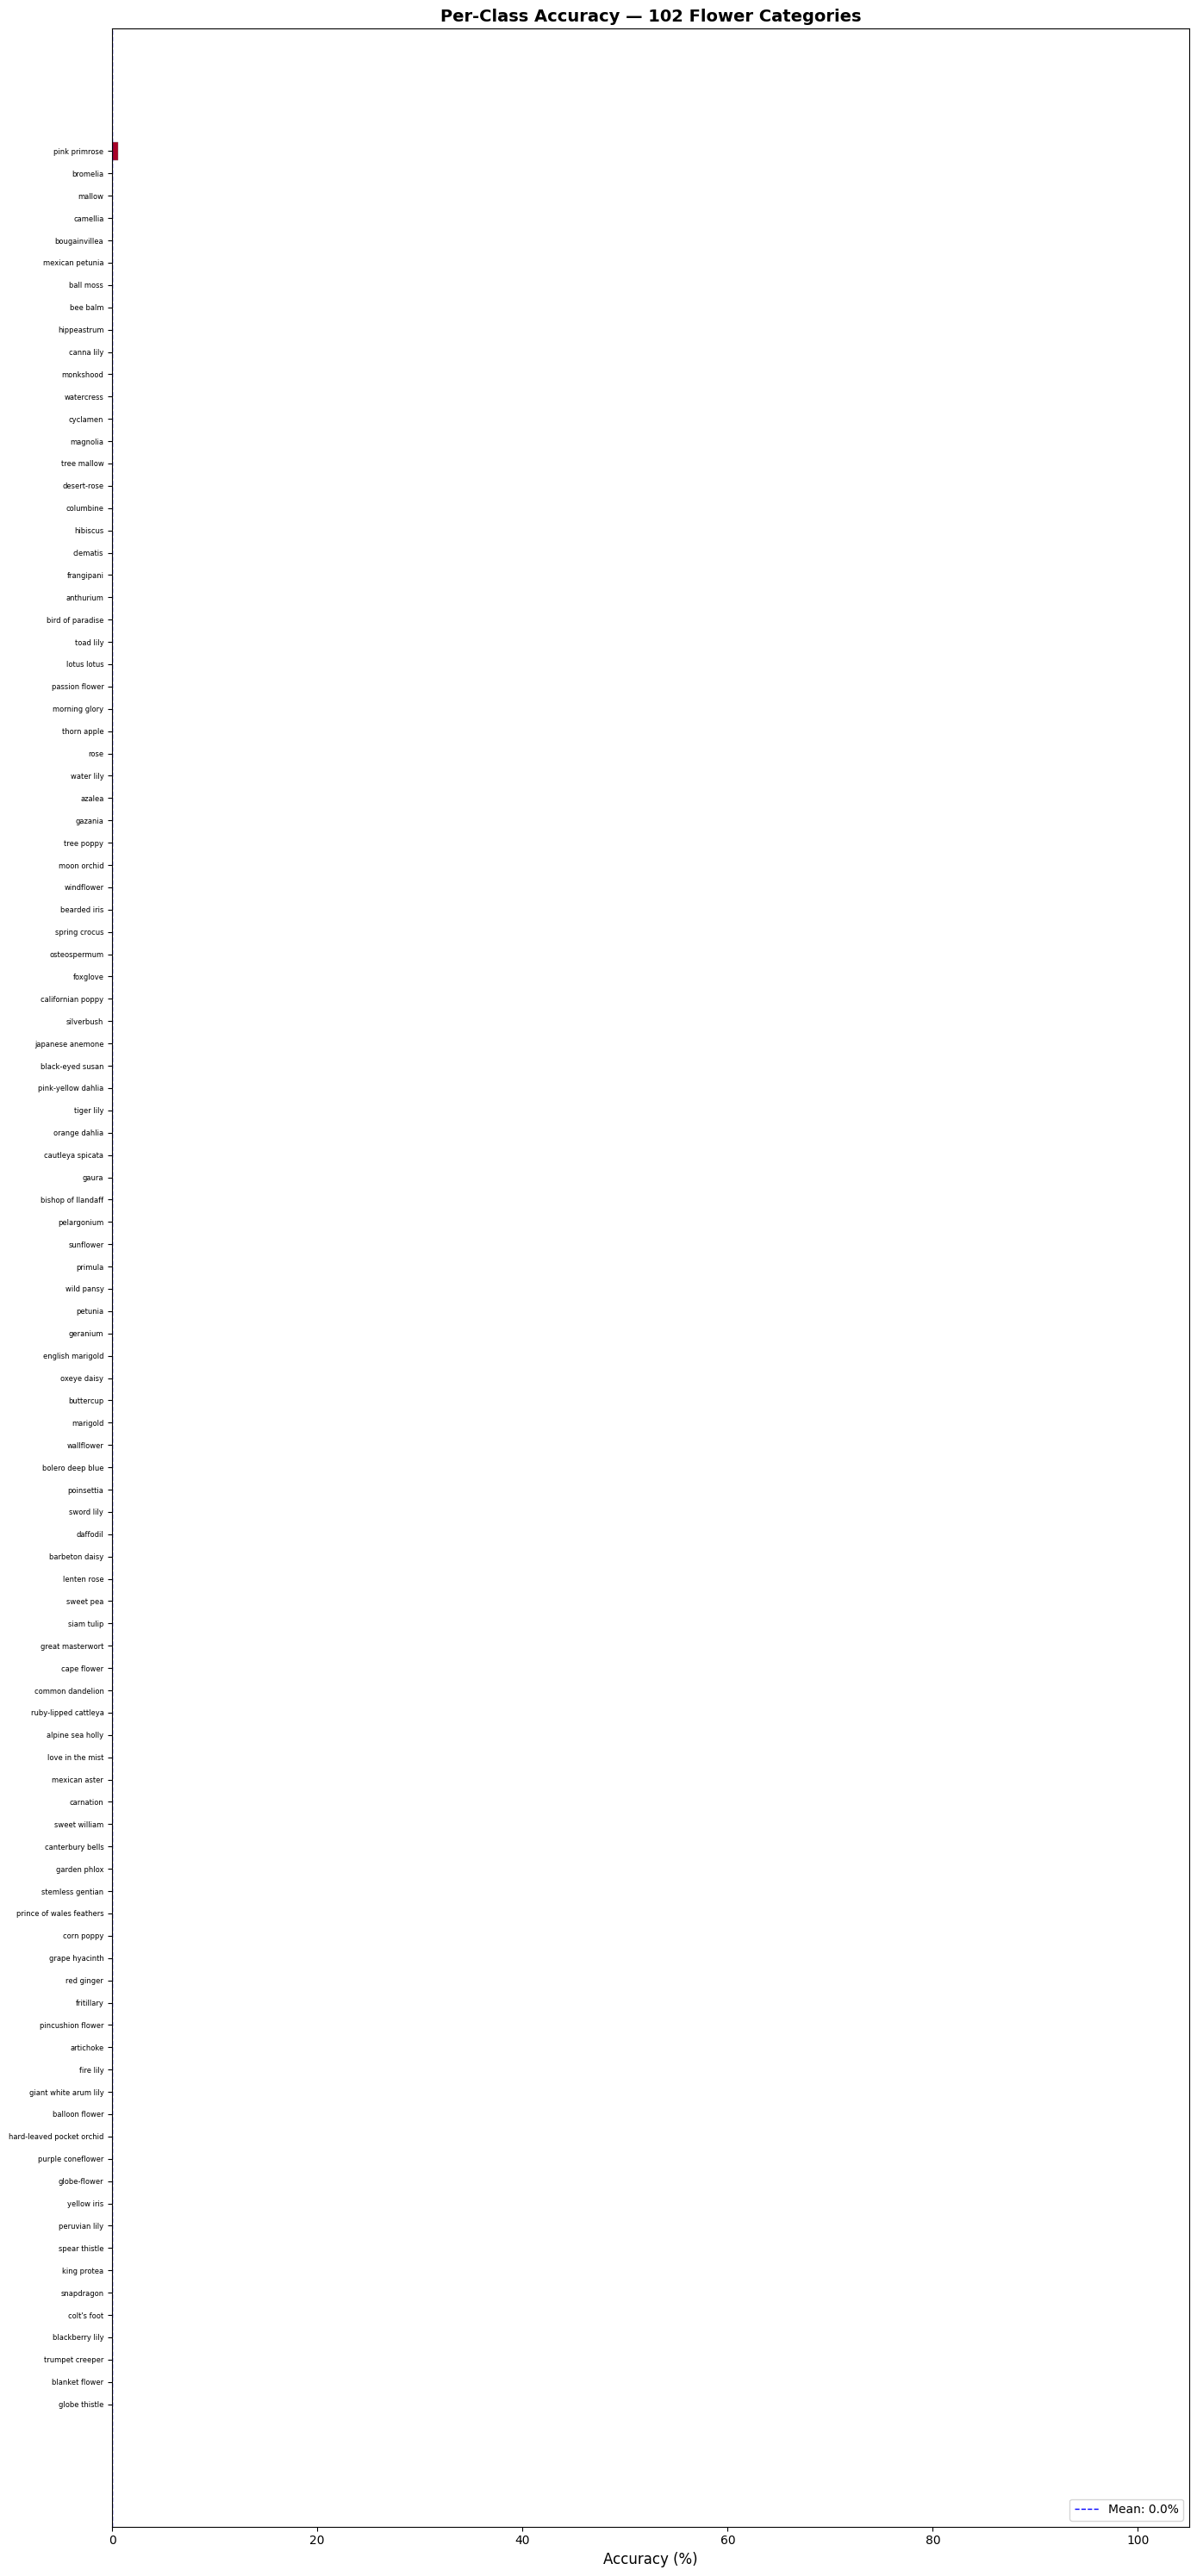

In [44]:
# ============================================================
# Per-Class Accuracy Bar Plot (all 102 classes)
# ============================================================

def plot_per_class_accuracy(per_class_df, save_path='per_class_accuracy.png'):
    """
    Horizontal bar plot of per-class accuracy for all 102 flower classes,
    colour-coded from red (worst) to green (best).
    """
    df = per_class_df.sort_values('Accuracy(%)', ascending=True).reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(14, 30))

    # Colour map: red → yellow → green
    cmap = plt.cm.RdYlGn
    norm = plt.Normalize(vmin=df['Accuracy(%)'].min(), vmax=100)
    colors = [cmap(norm(v)) for v in df['Accuracy(%)'].values]

    ax.barh(range(len(df)), df['Accuracy(%)'].values, color=colors, edgecolor='gray', linewidth=0.3)
    ax.set_yticks(range(len(df)))
    ax.set_yticklabels(df['Class'].values, fontsize=6)
    ax.set_xlabel('Accuracy (%)', fontsize=12)
    ax.set_title('Per-Class Accuracy — 102 Flower Categories', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 105)

    # Add a vertical line at mean accuracy
    mean_acc = df['Accuracy(%)'].mean()
    ax.axvline(x=mean_acc, color='blue', linestyle='--', linewidth=1.0, label=f'Mean: {mean_acc:.1f}%')
    ax.legend(fontsize=10, loc='lower right')

    plt.tight_layout()
    fig.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Per-class accuracy plot saved to '{save_path}'")
    plt.show()


plot_per_class_accuracy(per_class_df)